In [75]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.constants as cst
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
k_lamda=2*10**9*np.pi/1064
Er=1
V0=7*Er

In [77]:
def geteigen(V0,q):
    s=(2*np.linspace(-50,50,101)+q/(cst.hbar*k_lamda))**2*Er-0.5*V0
    hamiltonian=np.diag([-0.25*V0]*100,-1)+np.diag([-0.25*V0]*100,1)+np.diag(s)
    return np.sort(np.linalg.eigvals(np.matrix(hamiltonian)))

In [78]:
qlist=np.linspace(-1,1,50)*cst.hbar*k_lamda
eivallist=[]
for q in qlist:
    eivallist.append(geteigen(V0,q))
eivallist=np.array(eivallist)

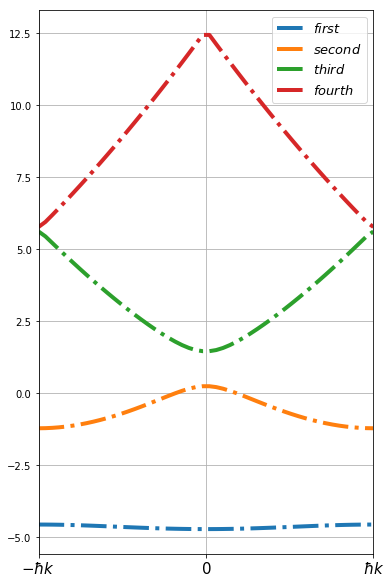

In [79]:
plt.figure(figsize=(6,10),linewidth=32)
plt.grid(True)
plt.xlim(-1,1)
plt.xticks(np.linspace(-1,1,3), ('$-\hbar k$','$0$','$\hbar k$'),fontsize='15')
#plt.yticks(np.linspace(-12,12,11),fontsize='15')
plt.plot(np.linspace(-1,1,50),eivallist[:,0],'-.',
         np.linspace(-1,1,50),eivallist[:,1],'-.',
         np.linspace(-1,1,50),eivallist[:,2],'-.',
         np.linspace(-1,1,50),eivallist[:,3],'-.',linewidth=4)
plt.legend(['$first$','$second$','$third$','$fourth$'],loc='best',fontsize='13')